#HW2 - Machine Learning 
##Louis de Leyritz, Felix Hans, Louis Le Bret, Lucas Héral 
###Team Last Minute

#Set-up

###Libraries and reading the datasets

In [ ]:
#Dowloading all the required libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive



In [ ]:
drive = drive.mount('/content/drive')#If you imported the datasets to your drive

Mounted at /content/drive


In [ ]:
#Reading up the datasets, don't forget to change paths
train_df = pd.read_csv('/content/drive/My Drive/Assignment3-Kaggle/train.csv', index_col=0) 
test_df = pd.read_csv('/content/drive/My Drive/Assignment3-Kaggle/test.csv', index_col=0)


In [ ]:
test_df.head()

,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body
0,"Wed, 1 Nov 2017 15:51:21 +0530",iiitd,ac.in,0,0,multipart/alternative,0,12,1,0,20.0,4505
1,"Thu, 05 Mar 2015 20:47:22 -0500",notifications,freelancer.com,0,0,multipart/alternative,7,49,1,0,49.0,32949
2,"Thu, 21 Apr 2016 14:53:08 +0530",iiitd,ac.in,1,0,multipart/alternative,0,0,1,0,24.0,1707
3,"Tue, 06 Feb 2018 12:12:08 +0000 (UTC)",udacity,com,0,0,multipart/alternative,13,50,1,0,70.0,76686
4,"Tue, 21 May 2019 05:56:27 -0700",google,com,0,0,text/html,18,76,1,0,38.0,22646


In [ ]:
train_df.head()

,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,label
0,"Mon, 6 Nov 2017 11:13:45 +0100",reply,ebay.in,0,0,multipart/alternative,35,120,0,0,49.0,80027,2
1,"Wed, 14 Feb 2018 11:00:16 -0000",edm,efinmail.com,0,0,multipart/alternative,1,7,0,0,107.0,2961,1
2,"Wed, 6 Jul 2016 19:53:37 +0000",usebackpack,com,0,0,text/html,4,17,0,0,35.0,25149,1
3,"Fri, 11 Oct 2019 11:25:40 +0200",granular,ai,0,0,multipart/mixed,0,0,0,0,15.0,635296,1
4,"Tue, 07 Nov 2017 11:07:18 +0000 (UTC)",github,com,1,0,multipart/alternative,2,11,0,0,49.0,2355,1


Both datasets were properly imported

###Preliminary work

In [ ]:
#We can drop all the rows which have NAs
train_df.dropna(axis=0, inplace=True)
train_df.set_index(np.arange(len(train_df)), inplace=True)


#Exploratory analysis and data pre-processing

##Exploratory analysis

In [ ]:
train_df.head()

,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,label
0,"Mon, 6 Nov 2017 11:13:45 +0100",reply,ebay.in,0,0,multipart/alternative,35,120,0,0,49.0,80027,2
1,"Wed, 14 Feb 2018 11:00:16 -0000",edm,efinmail.com,0,0,multipart/alternative,1,7,0,0,107.0,2961,1
2,"Wed, 6 Jul 2016 19:53:37 +0000",usebackpack,com,0,0,text/html,4,17,0,0,35.0,25149,1
3,"Fri, 11 Oct 2019 11:25:40 +0200",granular,ai,0,0,multipart/mixed,0,0,0,0,15.0,635296,1
4,"Tue, 07 Nov 2017 11:07:18 +0000 (UTC)",github,com,1,0,multipart/alternative,2,11,0,0,49.0,2355,1


In [ ]:
train_df.describe()

,ccs,bcced,images,urls,salutations,designation,chars_in_subject,chars_in_body,label
count,76639.000000,76639.000000,76639.000000,76639.000000,76639.000000,76639.000000,76639.000000,7.663900e+04,76639.000000
mean,0.493013,0.003001,8.185441,35.594032,0.403215,0.107543,51.295098,2.037541e+05,1.593810
std,3.249022,0.054700,312.408861,99.930351,0.490546,0.309805,33.744507,1.929287e+06,1.731882
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+00,0.000000
25%,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,32.000000,5.144000e+03,1.000000
50%,0.000000,0.000000,2.000000,18.000000,0.000000,0.000000,42.000000,2.138200e+04,1.000000
75%,0.000000,0.000000,9.000000,45.000000,1.000000,0.000000,62.000000,4.738700e+04,2.000000
max,179.000000,1.000000,83481.000000,21540.000000,1.000000,1.000000,606.000000,7.438108e+07,7.000000


Reminders:

0:Updates: banks, insurance, ...//
1: Personal: Mails from personal network //
2: Promotions: Promotional/advertisement mails //
3: Forums: Mails from professional groups //
4: Purchases: Updates about purchases //
5: Travel: Advertisement about travel and tourism //
6: Spam: Spam mails //
7: Social: Mails from social networks 

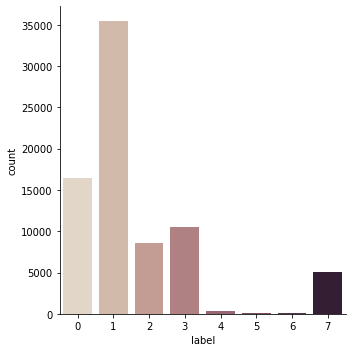

In [ ]:
#Lets view the repartion of the emails labels
sns.catplot(x="label", kind="count", palette="ch:.25", data=train_df)

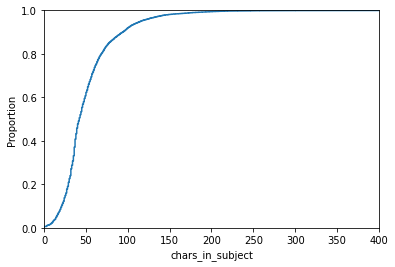

In [ ]:
#Number of characters distribution
#sns.displot(train_df, x="chars_in_body", kind="cdf")
plt.xlim(0,400)
sns.ecdfplot(data=train_df, x="chars_in_subject")


In [ ]:
print(len(train_df[train_df.chars_in_subject > 300]))

45


In [ ]:
#Organisations popularity
print(train_df['org'].value_counts())

iiitd             19938
usebackpack        5070
google             3890
amazon             3123
linkedin           2371
                  ...  
stockroom             1
meeshkan              1
mea                   1
mobikwik              1
kdc9otdk91qkqg        1
Name: org, Length: 1024, dtype: int64


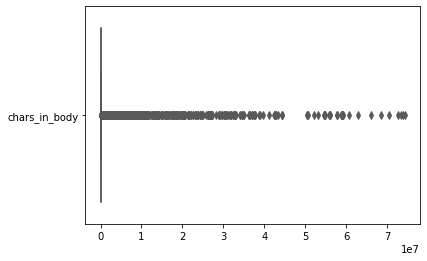

In [ ]:
#Distribution of the number of images in the emails
df_1 = train_df[['chars_in_body']]
ax = sns.boxplot(data=df_1, orient="h", palette="Set2") # There are a few outliers

In [ ]:
for col in train_df.select_dtypes(include=['object','category']).columns.tolist():
        train_df[col]=train_df[col].str.lower()

##Data pre-processing

###Date change

In [ ]:
#convert the date format into respective columns
# Retrieve day, month, time, year, number of day from the feature "date"
#function that converts all the values present in the 'date' column into a datetime value

import datetime
import re 

def date(date_string, i):
    
    date_string = re.sub("[\(\[].*?[\)\]]", "", str(date_string)).rstrip()
    if date_string[-4:] == '0580':
        date_string = date_string[:-5].rstrip()
        
    try:
        x = datetime.datetime.strptime(date_string, '%a, %d %b %Y %H:%M:%S %z')
        return x
    except ValueError:
        
        try:
            x = datetime.datetime.strptime(date_string, '%d %b %Y %H:%M:%S %z')
            return x
        except ValueError:
            
            try:
                x = datetime.datetime.strptime(date_string, '%a, %d %b %Y %H:%M:%S')
                return x
            except ValueError:
                
                try:
                    x = datetime.datetime.strptime(date_string, '%a, %d %b %Y %H:%M:%S %Z')
                    return x
                except ValueError:
                    try:
                        x = datetime.datetime.strptime(date_string, '%d %b %Y %H:%M:%S')
                        return x
                    except ValueError:
                        return i

In [ ]:
#create a list with datetime values 

datetime_type = []
for i in range(len(train_df)):
    datetime_type.append(date(train_df['date'][i], i))

In [ ]:
#find which values couldn't be converted 

to_drop = []
for i in range(len(datetime_type)):
    if type(datetime_type[i]) != datetime.datetime:
        to_drop.append(i)
to_drop

[40409, 65003]

In [ ]:
#drop the values that couldn't be converted

train_df.drop(to_drop, axis=0, inplace=True)
train_df.set_index(np.arange(len(train_df)), inplace=True)
k = 0
for i in range(len(to_drop)):
    datetime_type.pop(to_drop[i]-k)
    k += 1

In [ ]:
#create a new column with the datetime values using the previous created list datetime

#X['proper_date'] = np.zeros(len(X))
for i in range(len(train_df)):
    train_df['date'][i] = datetime_type[i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
#split-up time information
#SECONDS EXCLUDED BECAUSE NOT USEFUL - CHECK IF OTHER VARIABLES ARE USEFUL

train_df['year'] = np.zeros(len(train_df))
train_df['month'] = np.zeros(len(train_df))
#train_df['day'] = np.zeros(len(train_df))
train_df['day_of_week'] = np.zeros(len(train_df))
#train_df['hour'] = np.zeros(len(train_df))
#train_df['minute'] = np.zeros(len(train_df))
#train_df['timezone'] = np.zeros(len(train_df))

In [ ]:
#assign values to the new variables 

for i in range(len(train_df)):
    train_df['year'][i] =  train_df['date'][i].year
    train_df['month'][i] =  train_df['date'][i].month
    #train_df['day'][i] =  train_df['date'][i].day
    #train_df['hour'][i] =  train_df['date'][i].hour
    #train_df['minute'][i] =  train_df['date'][i].minute
    #train_df['timezone'][i] =  train_df['date'][i].tzinfo
    train_df['day_of_week'][i] = train_df['date'][i].weekday()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
#drop datetime

train_df = train_df.drop('date', axis = 1)

In [ ]:
train_df

,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,label,year,month,day_of_week
0,reply,ebay.in,0,0,multipart/alternative,35,120,0,0,49.0,80027,2,2017.0,11.0,0.0
1,edm,efinmail.com,0,0,multipart/alternative,1,7,0,0,107.0,2961,1,2018.0,2.0,2.0
2,usebackpack,com,0,0,text/html,4,17,0,0,35.0,25149,1,2016.0,7.0,2.0
3,granular,ai,0,0,multipart/mixed,0,0,0,0,15.0,635296,1,2019.0,10.0,4.0
4,github,com,1,0,multipart/alternative,2,11,0,0,49.0,2355,1,2017.0,11.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76632,amazon,in,0,0,multipart/mixed,0,0,0,0,15.0,4,1,2017.0,7.0,2.0
76633,quora,com,0,0,multipart/alternative,0,88,1,1,98.0,80913,1,2015.0,4.0,1.0
76634,github,com,1,0,multipart/alternative,0,8,0,0,91.0,1307,3,2020.0,6.0,1.0
76635,google,com,0,0,multipart/alternative,27,85,0,0,46.0,28485,0,2020.0,5.0,1.0


###Change image

In [ ]:
td = []
for i in range(len(train_df)):
    if train_df['images'][i] > 1000:
        td.append(i)
        
train_df.drop(td, axis=0, inplace=True)
train_df.set_index(np.arange(len(train_df)), inplace=True)

###Change URLs

In [ ]:
td = []
for i in range(len(train_df)):
    if train_df['urls'][i] > 1000:
        td.append(i)
        
train_df.drop(td, axis=0, inplace=True)
train_df.set_index(np.arange(len(train_df)), inplace=True)

###Change chars in subject  

In [ ]:
todrop = []
for i in range(len(train_df)):
    if train_df['chars_in_subject'][i] > 300:
        td.append(i)
        
train_df.drop(todrop , axis=0, inplace=True)
train_df.set_index(np.arange(len(train_df)), inplace=True)

###Change chars in body

In [ ]:
todrop = []
for i in range(len(train_df)):
    if train_df['chars_in_body'][i] > 10000000:
        td.append(i)
        
train_df.drop(todrop, axis=0, inplace=True)
train_df.set_index(np.arange(len(train_df)), inplace=True)

In [ ]:
# Split the data
def splitSet(dataset):
    return dataset.drop(['label'],axis=1), dataset[['label']]

X, y = splitSet(train_df.copy())
print("Shape of design matrix of training set:", X.shape)
print("Shape of labels matrix of training set:",y.shape)



Shape of design matrix of training set: (76623, 14)
Shape of labels matrix of training set: (76623, 1)


### Ratio & Mail types

In [ ]:
#image to chars-in-body
X['im_to_char_body-ratio'] = X['images'].astype(float)/X['chars_in_body'].astype(float)

#chars-in-subject to chars in body
X['char_in_sub_to_char_body-ratio'] = X['chars_in_subject'].astype(float)/X['chars_in_body'].astype(float)

#ccs to chars in body
X['css_to_char_body-ratio'] = X['ccs'].astype(float)/X['chars_in_body'].astype(float)

#urls to chars in body
X['url_to_chars_body-ratio'] = X['urls'].astype(float)/X['chars_in_body'].astype(float)

In [ ]:
#splitting mail type into two variable 
'''
train_df[['mail_type_1','mail_type_2']] = X['mail_type'].str.split('/',expand=True)
X = X.drop(columns='mail_type')

X['mail_type_1']= X['mail_type_1'].str.lower()
X['mail_type_2']= X['mail_type_2'].str.lower()
'''

#We tried to split the mail types but it did not increase the accuracy of models so we did not used it. 

"\ntrain_df[['mail_type_1','mail_type_2']] = X['mail_type'].str.split('/',expand=True)\nX = X.drop(columns='mail_type')\n\nX['mail_type_1']= X['mail_type_1'].str.lower()\nX['mail_type_2']= X['mail_type_2'].str.lower()\n"

###Org change

In [ ]:
# Org Converting the 10% least frequent variable to other
org_freq = (X['org'].value_counts())/X.shape[0]
bottom_decile = org_freq.quantile(q=0.9)
less_freq_org = org_freq[org_freq<=bottom_decile]
X.loc[X['org'].isin(less_freq_org.index.tolist()),'org'] = "other"
print(X['org'].value_counts())

iiitd           19927
other            9883
usebackpack      5070
google           3890
amazon           3123
                ...  
mapbox             95
deeplearning       93
plus               93
splitwise          92
emails             91
Name: org, Length: 102, dtype: int64


###Tld change

In [ ]:
# tld Converting the 10% least frequent variable to other
tld_freq = (X['tld'].value_counts())/X.shape[0]
bottom_decile = tld_freq.quantile(q=0.9)
less_freq_tld = tld_freq[tld_freq<=bottom_decile]
X.loc[X['tld'].isin(less_freq_tld.index.tolist()),'tld'] = "other"
print(X['tld'].value_counts())

com                  34596
ac.in                20026
other                 4385
in                    3776
org                   3447
fr                    1580
gov.in                1540
ai                     719
co.in                  704
netflix.com            629
net                    554
google.com             428
foodpanda.in           405
ebay.in                392
intercom-mail.com      304
co                     299
grammarly.com          277
mail.coursera.org      272
microsoft.com          247
bookmyshow.com         240
speakingtree.in        229
freelancer.com         222
sdconnect.in           214
gov                    214
linkedin.com           205
apple.com              199
org.in                 190
jp                     181
ibm.com                149
Name: tld, dtype: int64


### Correlation

In [ ]:
#Lets see the correlation between labels and other variables
X.corr() #only takes into account numerical variables


,ccs,bcced,images,urls,salutations,designation,chars_in_subject,chars_in_body,year,month,day_of_week,im_to_char_body-ratio,char_in_sub_to_char_body-ratio,css_to_char_body-ratio,url_to_chars_body-ratio
ccs,1.000000,0.000191,-0.065801,-0.087644,0.099992,-0.012329,-0.030992,0.009789,-0.050525,-0.000502,-0.007716,-0.072697,-0.019544,0.038172,-0.074907
bcced,0.000191,1.000000,-0.012103,-0.034288,0.026397,0.001747,-0.000343,0.043781,-0.000697,0.011223,-0.001963,-0.030355,-0.006286,0.004450,-0.028108
images,-0.065801,-0.012103,1.000000,0.582741,-0.090091,0.062656,0.130423,0.015068,0.062739,-0.003498,0.013545,0.426777,-0.068504,-0.011747,0.132094
urls,-0.087644,-0.034288,0.582741,1.000000,-0.056816,0.183341,0.291603,-0.029171,0.110950,0.002444,0.021127,0.274387,-0.103748,-0.017406,0.223891
salutations,0.099992,0.026397,-0.090091,-0.056816,1.000000,0.101217,-0.040106,0.074772,-0.058403,-0.006083,-0.002650,-0.230790,-0.112661,-0.003124,-0.108507
designation,-0.012329,0.001747,0.062656,0.183341,0.101217,1.000000,0.115916,-0.015823,0.022026,0.006348,-0.020248,-0.059164,-0.048440,-0.006411,-0.014283
chars_in_subject,-0.030992,-0.000343,0.130423,0.291603,-0.040106,0.115916,1.000000,-0.022729,0.102262,0.011458,-0.027375,0.046660,0.044687,-0.001494,0.027662
chars_in_body,0.009789,0.043781,0.015068,-0.029171,0.074772,-0.015823,-0.022729,1.000000,-0.013789,-0.002299,-0.015575,-0.059505,-0.014929,-0.002567,-0.099279
year,-0.050525,-0.000697,0.062739,0.110950,-0.058403,0.022026,0.102262,-0.013789,1.000000,-0.165565,-0.001783,0.076085,-0.028166,0.004110,0.135830
month,-0.000502,0.011223,-0.003498,0.002444,-0.006083,0.006348,0.011458,-0.002299,-0.165565,1.000000,-0.029087,-0.020122,0.000958,-0.017783,-0.052075


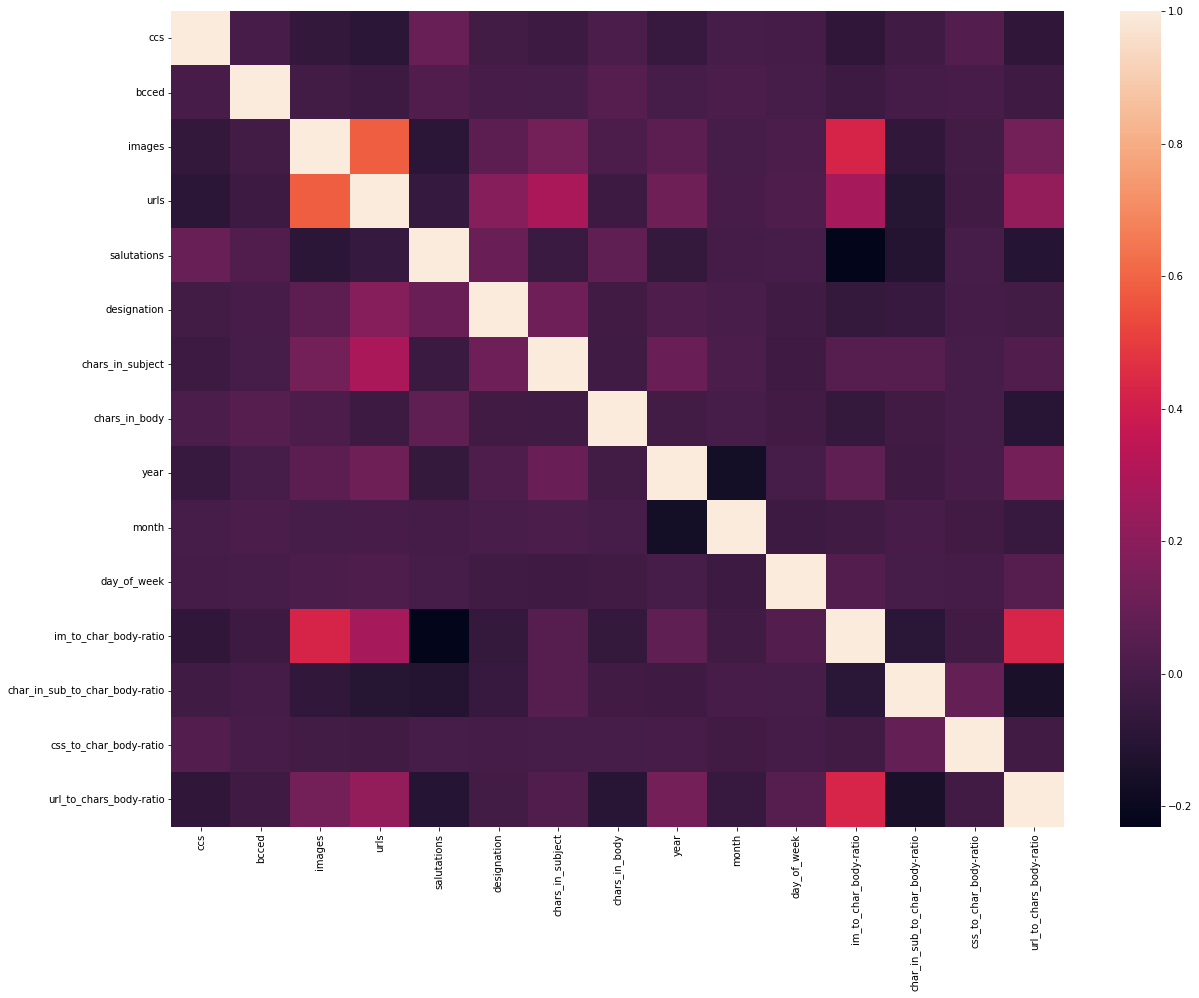

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(X.corr())

In [ ]:
test = X.select_dtypes(exclude=['object','category'])


test.dtypes

ccs                                 int64
bcced                               int64
images                              int64
urls                                int64
salutations                         int64
designation                         int64
chars_in_subject                  float64
chars_in_body                       int64
year                              float64
month                             float64
day_of_week                       float64
im_to_char_body-ratio             float64
char_in_sub_to_char_body-ratio    float64
css_to_char_body-ratio            float64
url_to_chars_body-ratio           float64
dtype: object

>Threshold=0.00, Features=15
>Threshold=0.01, Features=11
>Threshold=0.02, Features=11
>Threshold=0.03, Features=11
>Threshold=0.04, Features=11
>Threshold=0.05, Features=11
>Threshold=0.06, Features=11
>Threshold=0.07, Features=11
>Threshold=0.08, Features=11
>Threshold=0.09, Features=11
>Threshold=0.10, Features=10
>Threshold=0.11, Features=10
>Threshold=0.12, Features=10
>Threshold=0.13, Features=10
>Threshold=0.14, Features=10
>Threshold=0.15, Features=10
>Threshold=0.16, Features=10
>Threshold=0.17, Features=10
>Threshold=0.18, Features=10
>Threshold=0.19, Features=10
>Threshold=0.20, Features=10
>Threshold=0.21, Features=10
>Threshold=0.22, Features=10
>Threshold=0.23, Features=10
>Threshold=0.24, Features=10
>Threshold=0.25, Features=9
>Threshold=0.26, Features=9
>Threshold=0.27, Features=9
>Threshold=0.28, Features=9
>Threshold=0.29, Features=9
>Threshold=0.30, Features=9
>Threshold=0.31, Features=9
>Threshold=0.32, Features=9
>Threshold=0.33, Features=9
>Threshold=0.34, Featur

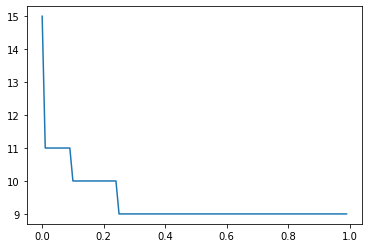

In [ ]:
#identify low variance features
# Define thresholds to check
thresholds = np.arange(0.0, 1, 0.010)
# Apply transform with each threshold
results = list()

for t in thresholds:
    transform = VarianceThreshold(threshold=t)
    #Tranformation of input
    X_sel = transform.fit_transform(X.select_dtypes(exclude=['object','category']))
    # Determine the number of input features
    n_features = X_sel.shape[1]
    print('>Threshold=%.2f, Features=%d' % (t, n_features))
    # Store the result
    results.append(n_features)
# Plot the threshold vs the number of selected features
plt.plot(thresholds, results)
plt.show()


In [ ]:
datavar = X.copy()

def variance_selector(data, threshold = 0.05):
    if threshold == 0:
        return data
    else:
        selector = VarianceThreshold(threshold)
        col1 = datavar.select_dtypes(exclude=['number']).columns.tolist()
        selector.fit(datavar[datavar.select_dtypes(include=['number']).columns]) 
        return data[list(set(col1+datavar.columns[selector.get_support(indices=True)].tolist()))] 

X_sel = variance_selector(X, threshold = 0.05)

In [ ]:
print(X.shape)
sorted(X.columns.tolist())

(76623, 18)


['bcced',
 'ccs',
 'char_in_sub_to_char_body-ratio',
 'chars_in_body',
 'chars_in_subject',
 'css_to_char_body-ratio',
 'day_of_week',
 'designation',
 'im_to_char_body-ratio',
 'images',
 'mail_type',
 'month',
 'org',
 'salutations',
 'tld',
 'url_to_chars_body-ratio',
 'urls',
 'year']

In [ ]:
print(X_sel.shape)
sorted(X_sel.columns.tolist())

#excluded variables:
#- 'char_in_sub_to_char_body'
#- 'css_to_char_body'
#- 'day'
#- 'hour'

(76623, 12)


['bcced',
 'ccs',
 'chars_in_body',
 'chars_in_subject',
 'designation',
 'images',
 'mail_type',
 'month',
 'org',
 'salutations',
 'tld',
 'urls']

### Chi square

In [ ]:
#Chi square tests the dependence of categorical features to the target categories
# For this, each feature must must be converted to numbers
#However, if there are too many possibilities per feature, the results are highly biased since dependency can incur by chance (e.g. org, tld)
#Therefore, we only include categorical variables with up to 12 classes (year)
X.describe()

,ccs,bcced,images,urls,salutations,designation,chars_in_subject,chars_in_body,year,month,day_of_week,im_to_char_body-ratio,char_in_sub_to_char_body-ratio,css_to_char_body-ratio,url_to_chars_body-ratio
count,76623.000000,76623.000000,76623.000000,76623.000000,76623.000000,76623.000000,76623.000000,7.662300e+04,76623.000000,76623.000000,76623.000000,76623.000000,76623.000000,76623.000000,76623.000000
mean,0.493011,0.003002,6.741709,34.933414,0.403143,0.107526,51.301946,2.021409e+05,2016.925545,6.559584,2.671013,0.000211,0.293916,0.000268,0.001359
std,3.249338,0.054706,13.868815,47.394284,0.490532,0.309783,33.743838,1.917403e+06,1.668738,3.322400,1.863160,0.000315,2.073747,0.010919,0.001260
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+00,2012.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,32.000000,5.143000e+03,2016.000000,4.000000,1.000000,0.000000,0.001113,0.000000,0.000559
50%,0.000000,0.000000,2.000000,18.000000,0.000000,0.000000,42.000000,2.136800e+04,2017.000000,7.000000,3.000000,0.000132,0.002195,0.000000,0.001109
75%,0.000000,0.000000,9.000000,45.000000,1.000000,0.000000,62.000000,4.735600e+04,2018.000000,9.000000,4.000000,0.000296,0.007431,0.000000,0.001923
max,179.000000,1.000000,1000.000000,711.000000,1.000000,1.000000,606.000000,7.438108e+07,2020.000000,12.000000,6.000000,0.025754,45.500000,1.000000,0.021277


In [ ]:
print(X['year'].value_counts())
row, col = X.shape

2016.0    17640
2017.0    17094
2018.0    12102
2015.0     9785
2019.0     9415
2020.0     5660
2014.0     3594
2013.0     1040
2012.0      293
Name: year, dtype: int64


In [ ]:
#X_chi = X.select_dtypes(include=['object','category'])
X_chi = pd.DataFrame(X['salutations'])
X_chi = X_chi.join(X['designation'])
X_chi = X_chi.join(X['bcced'])
X_chi = X_chi.join(X['day_of_week'])
X_chi = X_chi.join(X['year'])
X_chi = X_chi.join(X['month'])

X.dtypes
X_chi.head()
#X.describe()
#X_chi.shape

,salutations,designation,bcced,day_of_week,year,month
0,0,0,0,0.0,2017.0,11.0
1,0,0,0,2.0,2018.0,2.0
2,0,0,0,2.0,2016.0,7.0
3,0,0,0,4.0,2019.0,10.0
4,0,0,0,1.0,2017.0,11.0


In [ ]:
from sklearn.feature_selection import chi2

chi2(X_chi, y)

(array([2916.00494799, 1661.25030948,  114.01569754,  424.1249123 ,
           6.94860852,  392.41508468]),
 array([0.00000000e+00, 0.00000000e+00, 1.34644883e-21, 1.59277545e-87,
        4.34250296e-01, 1.00902197e-80]))

In [ ]:
X

,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,year,month,day_of_week,im_to_char_body-ratio,char_in_sub_to_char_body-ratio,css_to_char_body-ratio,url_to_chars_body-ratio
0,reply,ebay.in,0,0,multipart/alternative,35,120,0,0,49.0,80027,2017.0,11.0,0.0,0.000437,0.000612,0.000000,0.001499
1,edm,other,0,0,multipart/alternative,1,7,0,0,107.0,2961,2018.0,2.0,2.0,0.000338,0.036136,0.000000,0.002364
2,usebackpack,com,0,0,text/html,4,17,0,0,35.0,25149,2016.0,7.0,2.0,0.000159,0.001392,0.000000,0.000676
3,granular,ai,0,0,multipart/mixed,0,0,0,0,15.0,635296,2019.0,10.0,4.0,0.000000,0.000024,0.000000,0.000000
4,github,com,1,0,multipart/alternative,2,11,0,0,49.0,2355,2017.0,11.0,1.0,0.000849,0.020807,0.000425,0.004671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76618,amazon,in,0,0,multipart/mixed,0,0,0,0,15.0,4,2017.0,7.0,2.0,0.000000,3.750000,0.000000,0.000000
76619,quora,com,0,0,multipart/alternative,0,88,1,1,98.0,80913,2015.0,4.0,1.0,0.000000,0.001211,0.000000,0.001088
76620,github,com,1,0,multipart/alternative,0,8,0,0,91.0,1307,2020.0,6.0,1.0,0.000000,0.069625,0.000765,0.006121
76621,google,com,0,0,multipart/alternative,27,85,0,0,46.0,28485,2020.0,5.0,1.0,0.000948,0.001615,0.000000,0.002984


#Model selection 

###Random Forest 

In [ ]:
features_to_encode = X.columns[X.dtypes=='object'].tolist()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
col_trans = make_column_transformer(
                        (OneHotEncoder(),features_to_encode),
                        remainder = "passthrough")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=150,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=50,
                      max_features='auto')

In [ ]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(col_trans, rf_classifier)
pipe.fit(x_train, y_train)

NameError: ignored

In [ ]:
y_pred_rf = pipe.predict(x_test)

In [ ]:
#Get accuracy 
from sklearn.metrics import accuracy_score

print('Accuracy is ' + str(accuracy_score(y_test,y_pred_rf)))

###Logistic Regression 

In [ ]:
X_t = X
X_t = pd.get_dummies(X_t, columns=['mail_type'])
X_t = pd.get_dummies(X_t, columns=['tld'])
X_t = pd.get_dummies(X_t, columns=['org'])


In [ ]:
X_t

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.1, random_state=1, stratify=y)

In [ ]:
X_train

In [ ]:
#Feature scaling
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [ ]:
# Make an instance of the Model
pca = PCA(.95)

In [ ]:
pca.fit(X_train_std)

In [ ]:
train_pca = pca.transform(X_train_std)
test_pca = pca.transform(X_test_std)

In [ ]:
logreg = LogisticRegression()
logreg.fit(train_pca, y_train.values.ravel())

In [ ]:
y_pred_logreg = logreg.predict(test_pca)

In [ ]:
print('Accuracy ' + str(accuracy_score(y_test,y_pred_logreg)))

###Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

In [ ]:
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
print('Accuracy ' + str(accuracy_score(y_test,y_pred)))

###CatBoost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression, LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import matplotlib.patches as mpatches

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
#!pip install catboost

In [ ]:
X

In [ ]:
#Changing data types
X['org'] = X['org'].astype('|S')
X['tld'] = X['tld'].astype('|S')
#X['mail_type_1'] = X['mail_type_1'].astype('|S')
X['mail_type'] = X['mail_type'].astype('|S')

In [ ]:
label = y
train = X
x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.1, random_state=2)

In [ ]:
from catboost import CatBoostClassifier, Pool

#indicating which features are not categorical
categorical_features_indices = np.where(train.dtypes != np.float)[0]
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)

#actual model
cat = CatBoostClassifier(iterations=80, learning_rate=0.1, depth=10, one_hot_max_size=500)
cat.fit(train_pool)

#make prediction for evaluation
y_pred_cat = cat.predict(x_test)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.8504111	total: 767ms	remaining: 1m
1:	learn: 1.6942353	total: 1.5s	remaining: 58.4s
2:	learn: 1.5707138	total: 2.27s	remaining: 58.2s
3:	learn: 1.4734290	total: 3.01s	remaining: 57.3s
4:	learn: 1.3930749	total: 3.72s	remaining: 55.8s
5:	learn: 1.3274431	total: 4.47s	remaining: 55.1s
6:	learn: 1.2746550	total: 5.22s	remaining: 54.5s
7:	learn: 1.2256001	total: 5.92s	remaining: 53.3s
8:	learn: 1.1820130	total: 6.66s	remaining: 52.6s
9:	learn: 1.1438006	total: 7.38s	remaining: 51.7s
10:	learn: 1.1146697	total: 8.1s	remaining: 50.8s
11:	learn: 1.0849030	total: 8.83s	remaining: 50s
12:	learn: 1.0606381	total: 9.56s	remaining: 49.3s
13:	learn: 1.0366019	total: 10.3s	remaining: 48.5s
14:	learn: 1.0177399	total: 11s	remaining: 47.6s
15:	learn: 0.9983486	total: 11.7s	remaining: 46.7s
16:	learn: 0.9828551	total: 12.4s	remaining: 45.9s
17:	learn: 0.9677328	total: 13.1s	remaining: 45.2s
18:	learn: 0.9550104	total: 13.9s	remaining: 44.5s
19:	learn: 0.9419867	total: 14.6s	remaining: 43.7s

In [ ]:
print('Accuracy ' + str(accuracy_score(y_test, y_pred_cat)))

We can clearly see that catboost is the best model here. Therefore, we will try to tune the Catboost model in order to improve its accuracy.

# Tuning of our best model 

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [ ]:
from catboost import CatBoostClassifier, Pool

#indicating which features are not categorical
categorical_features_indices = np.where(train.dtypes != np.float)[0]

#X, y is for the final submission to include all data for testing
#Use x_train, y_train to use the train/test split
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)

#actual model
cat = CatBoostClassifier(iterations=311, learning_rate=0.2, depth=10, one_hot_max_size=500)
cat.fit(train_pool)

#make prediction for evaluation
y_pred_cat = cat.predict(x_test)

NameError: ignored

In [ ]:

#get accuracy

from sklearn.metrics import accuracy_score

print('Accuracy ' + str(accuracy_score(y_test, y_pred_cat)))

#Get the prediction on for the test dataset


###Processing of the test dataset

In [ ]:
test_df = pd.read_csv('/content/drive/My Drive/Assignment3-Kaggle/test.csv', index_col=0)

In [ ]:
len(test_df)

In [ ]:
test_df.dtypes

In [ ]:
len(test_df)

In [ ]:
datetime_type = []
for i in range(len(test_df)):
    datetime_type.append(date(test_df['date'][i], i))

In [ ]:
for col in test_df.select_dtypes(include=['object','category']).columns.tolist():
        test_df[col]=test_df[col].str.lower()

In [ ]:

to_drop = []
for i in range(len(datetime_type)):
    if type(datetime_type[i]) != datetime.datetime:
        to_drop.append(i)
to_drop[0]

In [ ]:

for i in range(len(test_df)):
    test_df['date'][i] = datetime_type[i]

In [ ]:
test_df['year'] = np.zeros(len(test_df))
test_df['month'] = np.zeros(len(test_df))
#test_df['day'] = np.zeros(len(test_df))
test_df['day_of_week'] = np.zeros(len(test_df))
#test_df['hour'] = np.zeros(len(test_df))

In [ ]:
#type(to_drop[0])
type(len(test_df))

In [ ]:
#assign values to the new variables 
test_df['year'][to_drop[0]] =  0
test_df['month'][to_drop[0]] =  0
#test_df['day'][to_drop[0]] =  0
#test_df['hour'][to_drop[0]] =  0
#train_df['minute'][to_drop[0]] =  0
#train_df['timezone'][to_drop[0]] =  0
test_df['day_of_week'][to_drop[0]] = 0


#range(to_drop[0]) + range(to_drop[0],len(test_df))
for i in [x for x in range(len(test_df)) if x != to_drop[0]]:
    test_df['year'][i] =  test_df['date'][i].year
    test_df['month'][i] =  test_df['date'][i].month
    #test_df['day'][i] =  test_df['date'][i].day
    #test_df['hour'][i] =  test_df['date'][i].hour
    #train_df['minute'][i] =  train_df['date'][i].minute
    #train_df['timezone'][i] =  train_df['date'][i].tzinfo
    test_df['day_of_week'][i] = test_df['date'][i].weekday()

In [ ]:
test_df = test_df.drop('date', axis = 1)

In [ ]:
test_df

In [ ]:
org_freq = (test_df['org'].value_counts())/test_df.shape[0]
bottom_decile = org_freq.quantile(q=0.9)
less_freq_org = org_freq[org_freq<=bottom_decile]
test_df.loc[test_df['org'].isin(less_freq_org.index.tolist()),'org'] = "other"
print(test_df['org'].value_counts())

In [ ]:
# tld Converting the 10% least frequent variable to other
tld_freq = (test_df['tld'].value_counts())/test_df.shape[0]
bottom_decile = tld_freq.quantile(q=0.9)
less_freq_tld = tld_freq[tld_freq<=bottom_decile]
test_df.loc[test_df['tld'].isin(less_freq_tld.index.tolist()),'tld'] = "other"
print(test_df['tld'].value_counts())

In [ ]:
test_df['chars_in_subject'] = test_df['chars_in_subject'].fillna(test_df['chars_in_subject'].median())
test_df['org'] = test_df['org'].fillna('NaN')
test_df['tld'] = test_df['tld'].fillna('NaN')
test_df['mail_type'] = test_df['mail_type'].fillna('NaN')

In [ ]:
test_df.isnull().sum()

In [ ]:
x_train.dtypes

In [ ]:
test_df.dtypes

In [ ]:
#image to chars-in-body
test_df['im_to_char_body-ratio'] = test_df['images'].astype(float)/test_df['chars_in_body'].astype(float)

#chars-in-subject to chars in body
test_df['char_in_sub_to_char_body-ratio'] = test_df['chars_in_subject'].astype(float)/test_df['chars_in_body'].astype(float)

#ccs to chars in body
test_df['css_to_char_body-ratio'] = test_df['ccs'].astype(float)/test_df['chars_in_body'].astype(float)

#urls to chars in body
test_df['url_to_chars_body-ratio'] = test_df['urls'].astype(float)/test_df['chars_in_body'].astype(float)

In [ ]:
#Changing data types
test_df['org'] = test_df['org'].astype('|S')
test_df['tld'] = test_df['tld'].astype('|S')
test_df['mail_type'] = test_df['mail_type'].astype('|S')
train.dtypes

###Prediction on the test dateset with our best performing model 

In [ ]:

#make prediction for evaluation
y_pred_cat = cat.predict(test_df)

#make prediction for evaluation
#y_pred_cat = cat.predict(train_df)

In [ ]:
y_pred_cat

In [ ]:
results = []
type(test_df)

In [ ]:
print(len(y_pred_cat))

In [ ]:
results = y_pred_cat
print(results)

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
results_df = results_df.rename(columns={0: 'label'})
results_df.head()

In [ ]:
#results = results.drop('prediction', axis = 1)
results_df['ID'] = results_df.index

In [ ]:
results_df=results_df[['ID','label']]

In [ ]:
results_df

In [ ]:
results_df.to_csv('results_test.csv',index= False ,header=True)